# Predicting Music Genre using Lyrics with Deep Learning


## Abstract

This research explores the use of neural networks in predicting music genres from song lyrics to enhance recommendation systems. Leveraging the MetroLyrics Dataset, our study emphasizes preprocessing for focused lyric-based analysis. Addressing genre distribution imbalance through categorical cross-entropy, our baseline models, including LSTM, GRU, and HAN, reveal bidirectional variants consistently outperforming non-bidirectional counterparts. The HAN-GRU model stands out, achieving a 59.98% accuracy. Hyperparameter tuning yields modest improvements, underscoring the baseline model's efficacy. Despite resource constraints, this study provides valuable insights into the synergy of lyrics, music genres, and machine learning. Future iterations, with enhanced computational resources, hold promise for further advancements in the dynamic realm of digital music consumption and recommendation systems.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

## Dataset

Our primary data source for this research was the MetroLyrics Dataset, initially accessible on Kaggle. However, it was removed by the original poster. Consequently, we conducted an extensive search across multiple GitHub repositories and successfully located the original dataset.

Due to its collaborative and open-source nature, the dataset exhibited diverse formats for transcribed lyrics, leading to a certain level of disorder. As a result, extensive data cleaning and preprocessing became necessary. Among the contents were instrumental tracks, which required exclusion. Furthermore, the task involved removing most punctuation, non-ASCII characters, and musical annotations like "Chorus" and "Verse" from the lyrics.

In [2]:
path = "data/lyrics.csv"

In [3]:
df = pd.read_csv(path)
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


### Dataset Preprocessing

In [4]:
null_values = df.isnull().sum()

print(f"Null Values in Each Column:\n{null_values}")

Null Values in Each Column:
index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64


In [5]:
df = df[df['lyrics'].notnull()]

For our data cleaning and pre-processing steps, we performed several steps:

- Removes punctuation marks from the 'lyrics' column.
- Eliminates song-related identifiers like [Chorus] or [Verse].
- Clears out instrumental tracks and songs without lyrics.
- Filters out entries with corrupted or non-ASCII characters, as well as those marked as 'not available' in the 'genre' column.

In [6]:
df["lyrics"] = df["lyrics"].str.replace("[-\?.\,\/#!$%\^&\*;:{}=\_~()]", ' ')

df["lyrics"] = df["lyrics"].str.replace("\[(.*?)\]", ' ')
df["lyrics"] = df["lyrics"].str.replace(r"\[.*?\]", " ", regex=True)
df["lyrics"] = df["lyrics"].str.replace("' | '", ' ')
df["lyrics"] = df["lyrics"].str.replace('x[0-9]+', ' ')

df = df[~df["lyrics"].str.contains(r'[^\x00-\x7F]+')]
df = df[df["lyrics"].str.strip() != '']
df = df[df["genre"].str.lower() != 'not available']

df = df[df["lyrics"].str.strip().str.lower() != "instrumental"]
df["lyrics"] = df["lyrics"].astype(str)

In [7]:
df["lyrics"][:10]

0    Oh baby, how you doing?\nYou know I'm gonna cu...
1    playin' everything so easy,\nit's like you see...
2    If you search\nFor tenderness\nIt isn't hard t...
3    Oh oh oh I, oh oh oh I\n \nIf I wrote a book a...
4    Party the people, the people the party it's po...
5    I heard\nChurch bells ringing\nI heard\nA choi...
6    This is just another day that I would spend\nW...
7    Waiting, waiting, waiting, waiting\nWaiting, w...
8     \nI read all of the magazines\nwhile waiting ...
9    N-n-now, honey\nYou better sit down and look a...
Name: lyrics, dtype: object

Since some of our lyrics contain non-english language lyrics, we utilized a library called langdetect to detect the language of the provided text, and filtered them out from our cleaned dataframe.

In [ ]:
tqdm.pandas()

In [ ]:
from langdetect import detect

def filter_non_english_lyrics(df):
    def is_english(text):
        try:
            return detect(text[:10000]) == 'en'  # Detect language using only the first 5000 characters
        except:
            return False

    english_lyrics_mask = df['lyrics'].progress_apply(is_english)
    english_lyrics_df = df[english_lyrics_mask].reset_index(drop=True)
    return english_lyrics_df

### Exploratory Data Analysis

We decided to perform EDA on our dataset to see what our dataset contained. We were most concerned about the balance of our dataset since an imbalance dataset could potentially cause issues while training our models.

In [8]:
df = pd.read_csv("data/lyrics_cleaned.csv")
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n \nIf I wrote a book a..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


Taking advantage of pandas, we converted our cleaned and preprocessed dataset into a dataframe and plotted out the value_counts of our genre column.

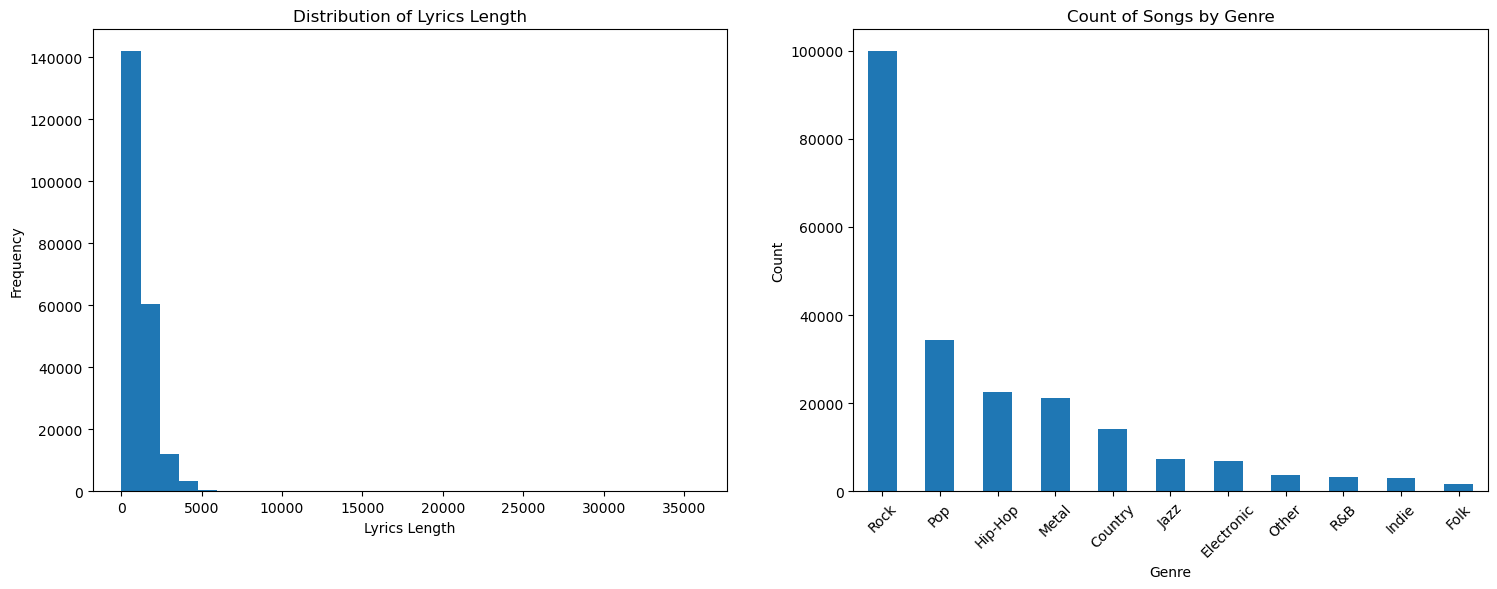

In [10]:
# Text Analysis
df['lyrics_length'] = df['lyrics'].apply(len)

plt.figure(figsize=(18, 6))

# Subplot 1: Distribution of lyrics length
plt.subplot(1, 2, 1)
plt.hist(df['lyrics_length'], bins=30)
plt.xlabel('Lyrics Length')
plt.ylabel('Frequency')
plt.title('Distribution of Lyrics Length')

# Subplot 2: Count of Songs by Genre
plt.subplot(1, 2, 2)
df['genre'].value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Songs by Genre')
plt.xticks(rotation=45)

plt.show()

Upon analyzing the figure, it became evident that there is a significant imbalance in our dataset. The “Rock” genre overwhelmingly dominates, with the count of songs being notably higher than in other genres. This imbalance could lead to a model bias towards the “Rock” genre, impacting the performance and accuracy of predictions for other genres.

To mitigate this issue and enhance the model’s ability to generalize across all genres, we will employ categorical cross-entropy as our loss function during model training. Categorical cross-entropy is particularly adept at handling classification problems where classes are imbalanced and ensures that the model learns effectively from each class by penalizing misclassifications proportionally to their severity.

In [11]:
from wordcloud import WordCloud

In [16]:
sampled_df = df.sample(10000)
df_top_genres = sampled_df[sampled_df['genre'].isin(['Rock', 'Pop', 'Country', 'Folk'])]

Here we examine common words occurring in four out of ten genres in the dataset. We noticed commonly shared words among certain genres, emphasizing the importance of considering the context of lyrics rather than focusing solely on single words for our models.

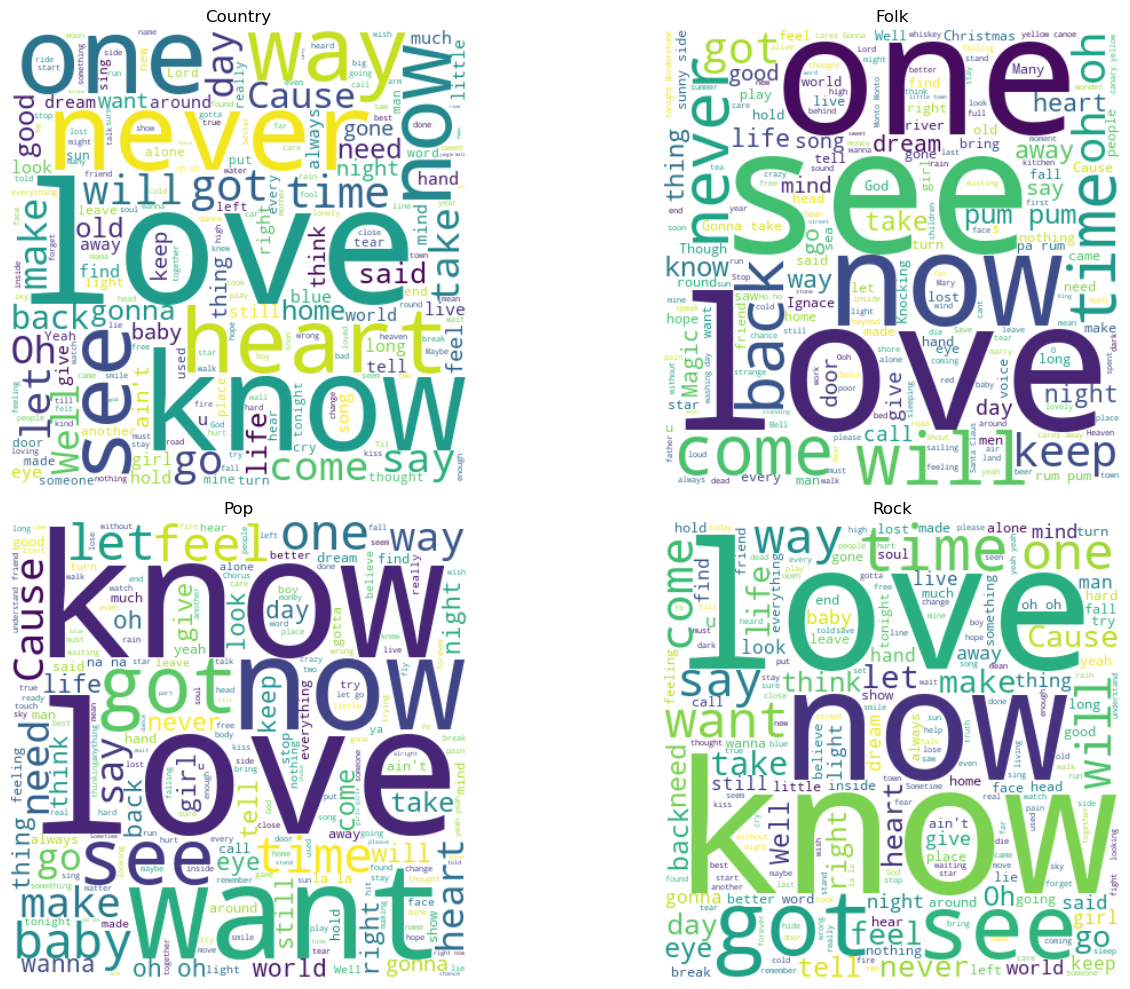

In [17]:
genre_lyrics = df_top_genres.groupby('genre')['lyrics'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(15, 10))
for i, (genre, lyrics) in enumerate(genre_lyrics.items(), start=1):
    plt.subplot(2, 2, i)
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(lyrics)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(genre)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Training Baseline Models

Given the substantial size of our dataset, particularly due to the extensive word count within lyrics, we opted to train our baseline models using a subset of 25,000 randomly selected data points from our preprocessed dataset. This decision stemmed from challenges related to RAM limitations and the considerable time required for model training.

In [20]:
import torch

from torch import nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import TruncatedSVD


from torchtext.data import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab, build_vocab_from_iterator

In [21]:
df = pd.read_csv("data/lyrics_cleaned.csv")
df = df.sample(25000)

Tokenizing lyrics...

In [22]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in tqdm(df['lyrics']):
    counter.update(tokenizer(line))

100%|███████████████████████████████████████████████████████████████| 25000/25000 [00:05<00:00, 4599.62it/s]


Building a vocabulary from tokenized lyrics...

In [23]:
vocab = build_vocab_from_iterator([tokenizer(line) for line in df['lyrics']],
                                  specials=['<unk>', '<pad>'], min_freq=1)

We converted the lyrics into numerical indices using a vocabulary and tokenizer and stored the results as PyTorch tensors. We also calculated the maximum sequence length among the indexed sequences.

In [24]:
label_encoder = LabelEncoder()
indexed_data = [torch.tensor([vocab[token] for token in tokenizer(line)])
                for line in df['lyrics']]

max_seq_length = max(len(seq) for seq in indexed_data)

We create a padded sequence `padded_data` by applying padding to the indexed lyrics data `indexed_data`. The padding ensures a uniform batch size. 

Additionally, we generate indexed labels `indexed_labels` by transforming genre labels from the DataFrame (df) into numerical indices using a label encoder.

In [36]:
padded_data = pad_sequence(indexed_data, batch_first=True, padding_value=vocab['<pad>'])
indexed_labels = torch.tensor(label_encoder.fit_transform(df['genre']))

Here, we create DataLoader instances `train_dataloader` and `validation_dataloader` to handle batches of data during training and validation.

In [26]:
class LyricsDataset(Dataset):
    def __init__(self, lyrics, genre):
        self.lyrics = lyrics
        self.genre = genre

    def __len__(self):
        return len(self.genre)

    def __getitem__(self, idx):
        return self.lyrics[idx], self.genre[idx]

dataset = LyricsDataset(padded_data, indexed_labels)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

20,000 training samples
5,000 validation samples


In [27]:
batch_size=32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

## Vanilla LSTM Model

We explored multiple baseline models in this study. One of our chosen baselines featured a standard recurrent neural network, specifically a vanilla LSTM cell comprising 128 hidden units.

LSTMs can be effective for predicting genres from music lyrics due to their ability to capture sequential information and handle temporal dependencies within the text data.

In [31]:
from torchviz import make_dot

In [28]:
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output

In [32]:
vocab_size = len(vocab)
embedding_dim = 1024
hidden_dim = 60
output_size = len(df['genre'].unique())

This is what our model looks like when passed with a dummy input.

In [33]:
model = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, output_size)
print(model)

SimpleLSTM(
  (embedding): Embedding(73344, 1024)
  (lstm): LSTM(1024, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=11, bias=True)
)


In [35]:
dummy_input = torch.zeros((1, 1), dtype=torch.long)
output = model(dummy_input)
graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("simple_lstm_model", format="png")

'simple_lstm_model.png'

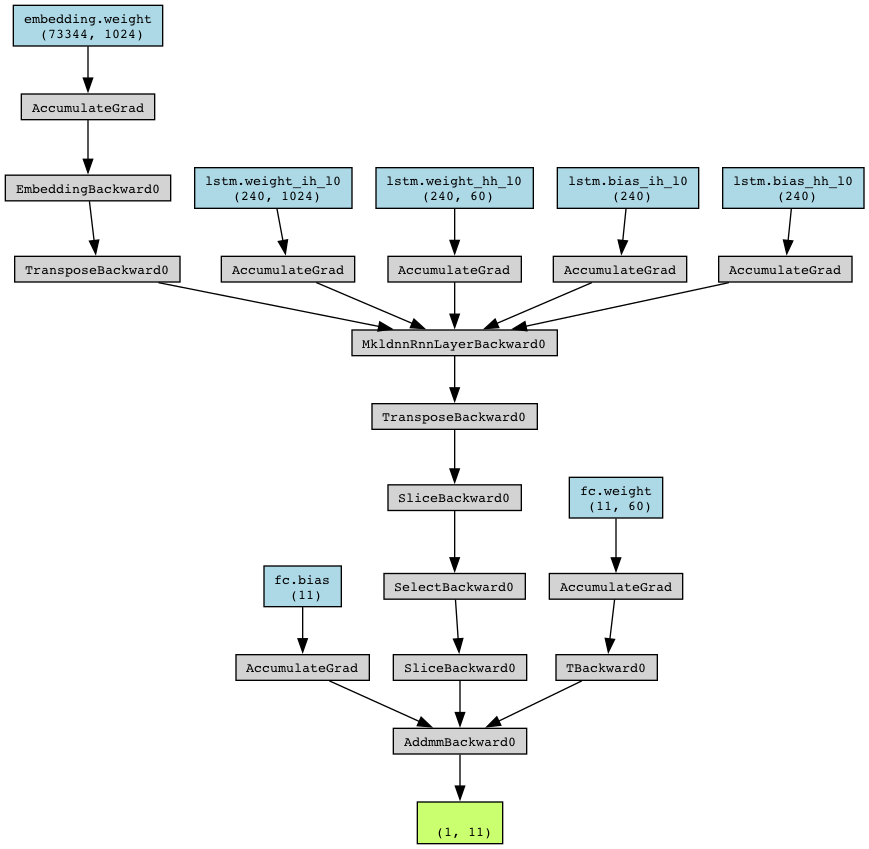

### Training

In [37]:
model = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, output_size)

We will employ categorical cross-entropy as our loss function during model training. Categorical cross-entropy is particularly adept at handling classification problems where classes are imbalanced and ensures that the model learns effectively from each class by penalizing misclassifications proportionally to their severity.

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

In [ ]:
for epoch in tqdm(range(num_epochs)):
    # Set model to training mode
    model.train()
    running_loss = 0.0
    num_correct = 0
    total = 0
    
    # Iterate over batches
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        num_correct += (predicted == labels).sum().item()  # Accumulate correct predictions
        total += labels.size(0) 
        
        running_loss += loss.item()

    # Calculate average training loss and accuracy per epoch
    accuracy = 100 * num_correct / total
    avg_train_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [ ]:
model.eval()
val_running_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in validation_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        val_running_loss += val_loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_val_loss = val_running_loss / len(validation_dataloader)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

### **The results for this model is in the final report.**

## Bidirectional LSTM Model

In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        # Concatenate the last hidden state from both directions
        combined = torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1)
        output = self.fc(combined)
        return output

In [ ]:
vocab_size = len(vocab)
embedding_dim = 1024
hidden_dim = 60
output_size = len(df['genre'].unique())

In [ ]:
model = BidirectionalLSTM(vocab_size, embedding_dim, hidden_dim, output_size)
print(model)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Vanilla GRU Model

In [39]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(SimpleGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        output = self.fc(gru_out[:, -1, :])  # Get the last output
        return output

In [40]:
# Define hyperparameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
output_size = len(df['genre'].unique())

In [41]:
# Initialize the model
model = SimpleGRU(vocab_size, embedding_dim, hidden_dim, output_size)
print(model)

SimpleGRU(
  (embedding): Embedding(73344, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)


In [44]:
dummy_input = torch.zeros((1, 1), dtype=torch.long)
output = model(dummy_input)
graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("simple_gru_model", format="png")

'simple_gru_model.png'

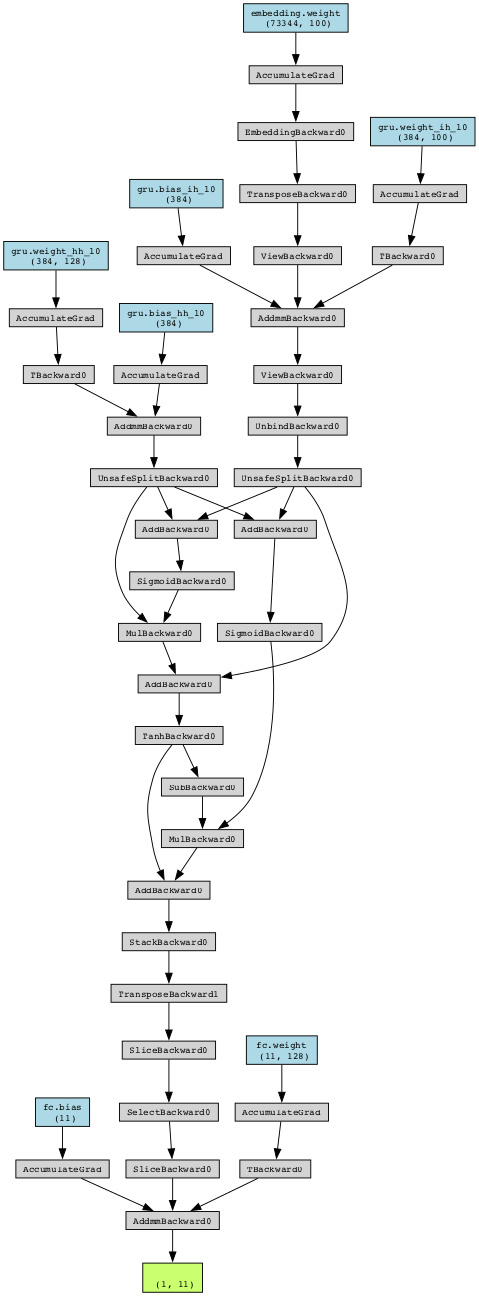

In [45]:
model = SimpleGRU(vocab_size, embedding_dim, hidden_dim, output_size)

In [42]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
# Training loop
num_epochs = 10  # Number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cpu
